In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq

from dwave.system import LeapHybridCQMSampler
from dimod import Binary, ConstrainedQuadraticModel

from codon_hamiltonian import *

In [2]:
ref_HPDF_DNA = 'GAGGGCCCGGCGCTGCGGCGCTCCTATTGGCGCCACCTGAGGCGTCTGGTGCTGGGTCCTCCCGAACCGCCGTTCTCGCACGTGTGCCAAGTCGGGGACCCGGTGCTGCGCGGCGTGGCGGCCCCGGTGGAGCGGGCGCAGCTAGGCGGGCCCGAGCTGCAGCGGCTGACGCAACGGCTGGTCCAGGTGATGCGGCGGCGGCGCTGCGTGGGCCTAAGCGCGCCGCAGCTGGGGGTGCCGCGGCAGGTGCTGGCGCTGGAGCTCCCCGAGGCGCTGTGTCGGGAGTGCCCGCCCCGCCAGCGCGCGCTCCGCCAAATGGAGCCCTTCCCCCTGCGCGTGTTCGTGAACCCCAGCCTGCGAGTGCTTGACAGCCGCCTGGTCACCTTTCCCGAGGGCTGCGAGAGCGTCGCCGGCTTCCTGGCCTGCGTGCCCCGCTTCCAGGCGGTGCAGATCTCAGGGCTGGACCCCAATGGAGAACAGGTGGTGTGGCAGGCGAGCGGGTGGGCAGCCCGCATCATCCAGCACGAGATGGACCACCTGCAGGGCTGCCTGTTTATTGACAAAATGGACAGCAGGACGTTCACAAACGTCTATTGGATGAAGGTGAATGAC'
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'

## 1. Construct Constraint Quadratic Models

### 1-1. Codon Objectives

In [3]:
block_size = 5
block_position = 0

#amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
#H_codon = Codon_Hamiltonian(amino_fragment, weight_params={})
H_codon = Codon_Hamiltonian(HPDF_amino, weight_params={})

cqm = ConstrainedQuadraticModel()

#### 1-1-1. Codon Usage Bias

$$
\min \sum^N_{i} - (\log f_i)q_i,
$$
where $f_{i|k}$ is the frequency of codon usage for $i$th synonymous codon in amino acid $k$. <br>
One can find these values from the codon usage table.

In [4]:
var_q = [Binary(f'q_{i}') for i in range(H_codon.N)]
cub_ec_obj = sum((-1) * H_codon.vec_zeta(host='e_coli_316407') * var_q)
cub_hu_obj = sum((-1) * H_codon.vec_zeta(host='h_sapiens_9606') * var_q)
#cqm.set_objective(codon_objective)

In [5]:
cub_obj = cub_ec_obj + cub_hu_obj
#cub_obj

#### 1-1-2. Codon Pair Usage Bias

**Codon Pair Score**
$$
CPS(i, l, j, l+1) = \ln f_{ij|l(l+1)} - \ln f_{i|l} - \ln f_{j|l+1}
$$

In [6]:
host = 'ecoli' #'human'
pcpt = pd.read_csv('./CodonPair_jhlee/CPS_'+host+'.csv')
pcpt

,AminoPair,CodonPair,Observed,Expected,Ob/Ex,CPS
0,AA,GCTGCA,1078,849.0720,1.269621,0.238719
1,AA,GCCGCG,1751,2456.2440,0.712877,-0.338446
2,AA,GCCGCA,1725,1432.8090,1.203929,0.185590
3,AA,GCCGCC,2238,1842.1830,1.214863,0.194631
4,AA,GCCGCT,1314,1091.6640,1.203667,0.185373
...,...,...,...,...,...,...
3716,YW,TACTGG,996,493.2100,2.019424,0.702812
3717,YY,TATTAT,547,833.0436,0.656628,-0.420637
3718,YY,TATTAC,906,628.4364,1.441673,0.365804
3719,YY,TACTAT,428,628.4364,0.681055,-0.384112


$$
\min \sum^{N-1}_{l=1} - CPS(i,l,j,l+1)q_{i|l}q_{j|l+1},
$$

In [7]:
mat_ec = H_codon.matrix_CPS(host='ecoli')
mat_hu = H_codon.matrix_CPS(host='human')
nonzeros = np.argwhere(mat_ec)
cpub_ec_obj = 0
cpub_hu_obj = 0
for pos in nonzeros:
    i,j = pos
    cpub_ec_obj -= mat_ec[i,j] * var_q[i] * var_q[j]
    cpub_hu_obj -= mat_hu[i,j] * var_q[i] * var_q[j]

#### 1-1-3. Repeated Nucleotides

$$
\mathcal{H}_R = c_R\sum^N_i\sum^{N}_{j<i} R_{ij}q_iq_j,
$$
$$
R_{ij} = r(C_i, C_J) \kappa_{i,j}
$$

In [8]:
H_codon.matrix_R()

R = H_codon.matrix_R()
nonzeros = np.argwhere(R)
rep_nuc_obj = 0
for pos in nonzeros:
    i,j = pos
    #print(R[i,j],f"({i},{j})")
    rep_nuc_obj += R[i,j] * var_q[i] * var_q[j]
#codon_objective2 = 0.1 * codon_objective2
#cqm.set_objective(codon_objective2)

* test

In [9]:
wp = {'cub_ec': 1, 'cub_hu': 1, 'cpub_ec': 1, 'cpub_hu': 1, 'rep_nuc': 1}
cqm.set_objective(wp['cub_ec']*cub_ec_obj + wp['cub_hu']*cub_hu_obj \
                    + wp['cpub_ec']*cpub_ec_obj + wp['cpub_hu']*cpub_hu_obj + wp['rep_nuc']*rep_nuc_obj)

### 1-2 Constraints

#### Constraint 1: Only one codon per amino acid

$$
\sum_{i_a=1}^{N_a} q_i = 1, \forall a \in \text{amino acid seq}
$$
$i_a$ denotes possible codon in position $i$ for an amino acid $a$ <br>
$N_a$ denotes the number of all possible codons for an amino acid $a$

In [10]:
N_accumulated = 0
for aa in range(H_codon.len_aa_seq):
    #print('amino acid:',aa)
    
    # the number of codons per amino acid
    num_c_per_aa = len(H_codon.list_all_possible_codons[aa])

    # Constraints per amino acid
    one_amino_acid = [var_q[i] for i in range(N_accumulated, N_accumulated+num_c_per_aa)]

    # Add Constraints
    cqm.add_constraint(sum(one_amino_acid) == 1, label=f'Codon Selection in position {aa}, "{H_codon.amino_acid_seq[aa]}"')
        
    # the cumulative number of all possible codons
    N_accumulated += num_c_per_aa

#### Constraint 2: GC contents

$$
\rho_{GC} := \frac{1}{L}\sum_i s_iq_i 
$$

In [11]:
gc_avg_constraint = sum(H_codon.vec_s() * var_q) / H_codon.L

$$
\rho_{GC} = \rho_T
$$

In [12]:
rho_T= 0.7
bound = 0.0
#cqm.add_constraint(gc_avg_constraint == rho_T, label=f'GC average: {rho_T}')

$$
|\rho_{GC}-\rho_T | \le B_\rho
$$

In [13]:
rho_T= 0.7
bound = 0.0
cqm.add_constraint(gc_avg_constraint - rho_T <= bound, label=f'upper bound of GC average: {rho_T}')
cqm.add_constraint(gc_avg_constraint - rho_T >= - bound, label=f'lower bound of GC average: {rho_T}')

'lower bound of GC average: 0.7'

### 1-2. LeaphybridCQMSolver

In [14]:
sampler = LeapHybridCQMSampler()

In [ ]:
sampleset = sampler.sample_cqm(cqm,
                                #time_limit=20,    
                                label="Codon CQM")
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
if len(feasible_sampleset):
    best = feasible_sampleset.first
    print("{} feasible solutions of {}.".format(
        len(feasible_sampleset), len(sampleset)))

In [ ]:
selected_codon = [key for key, val in best.sample.items() if 'q' in key and val]
selected_codon

NameError: name 'best' is not defined

In [18]:
feasible_sampleset.first

Sample(sample={'q_0': 1.0, 'q_1': 0.0, 'q_10': 1.0, 'q_11': 0.0, 'q_12': 0.0, 'q_13': 0.0, 'q_14': 0.0, 'q_15': 0.0, 'q_16': 1.0, 'q_17': 0.0, 'q_18': 0.0, 'q_19': 0.0, 'q_2': 0.0, 'q_3': 0.0, 'q_4': 0.0, 'q_5': 1.0, 'q_6': 0.0, 'q_7': 0.0, 'q_8': 0.0, 'q_9': 1.0}, energy=20.020053441245608, num_occurrences=1, is_feasible=True, is_satisfied=array([ True,  True,  True,  True,  True,  True]))

## 2. Simuluation

In [3]:
len(HPDF_amino)

204

In [4]:
block_size = 204
block_position = 0

weight_params = {'c_f': 0.01, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}
amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
H_codon = Codon_Hamiltonian(amino_fragment, weight_params)

cqm = ConstrainedQuadraticModel()

#### Objective and Constraints

In [5]:
weight_params = {'c_f': 0.01, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6}

# Objective
# 1. codon usage bias
var_q = [Binary(f'q_{i}') for i in range(H_codon.N)]
cub_ecoli = sum((-1) * H_codon.vec_zeta(host='e_coli_316407') * var_q)
cub_human = sum((-1) * H_codon.vec_zeta(host='h_sapiens_9606') * var_q)

# 2. repeated nucleotide sequence
#H_codon.matrix_R()
R = H_codon.matrix_R()
nonzeros = np.argwhere(R)
repeated_ncltd = 0
for pos in nonzeros:
    i,j = pos
    repeated_ncltd += R[i,j] * var_q[i] * var_q[j]

cqm.set_objective(cub_ecoli + cub_human + repeated_ncltd) #+ cub_human

# Constraint 1
N_accumulated = 0
for aa in range(H_codon.len_aa_seq):
    #print('amino acid:',aa)
    
    # the number of codons per amino acid
    num_c_per_aa = len(H_codon.list_all_possible_codons[aa])

    # Constraints per amino acid
    one_amino_acid = [var_q[i] for i in range(N_accumulated, N_accumulated+num_c_per_aa)]

    # Add Constraints
    cqm.add_constraint(sum(one_amino_acid) == 1, label=f'Codon Selection in position {aa}, "{HPDF_amino[aa]}"')
        
    # the cumulative number of all possible codons
    N_accumulated += num_c_per_aa

# Constraint 2
gc_avg_constraint = sum(H_codon.vec_s() * var_q) / H_codon.L
rho_T= 0.6
# Inequality Constraint for GC avg
cqm.add_constraint(gc_avg_constraint <= (rho_T), label=f'upper bound of GC average: {rho_T}')
# Equality Constraint for GC avg
#cqm.add_constraint(gc_avg_constraint == rho_T, label=f'GC average: {rho_T}')


'upper bound of GC average: 0.6'

#### Sampling

In [6]:
sampler = LeapHybridCQMSampler()

sampleset = sampler.sample_cqm(cqm,
                                #time_limit=20,    
                                label="Codon CQM")
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
if len(feasible_sampleset):
    best = feasible_sampleset.first
    print("{} feasible solutions of {}.".format(
        len(feasible_sampleset), len(sampleset)))

selected_codon = [key for key, val in best.sample.items() if 'q' in key and val]
#print(selected_codon)
selected_codon = sorted([int(x[2:]) for x in selected_codon])
print(selected_codon)

46 feasible solutions of 51.
[0, 5, 8, 13, 16, 25, 29, 32, 38, 40, 46, 48, 51, 60, 66, 68, 75, 78, 86, 87, 91, 95, 97, 103, 105, 109, 114, 117, 120, 122, 124, 130, 132, 136, 139, 143, 150, 154, 158, 161, 167, 169, 174, 178, 182, 188, 190, 192, 198, 204, 205, 210, 213, 218, 224, 227, 234, 236, 242, 244, 251, 254, 257, 259, 265, 271, 272, 281, 284, 287, 293, 296, 300, 306, 310, 315, 317, 325, 328, 333, 339, 341, 344, 347, 355, 357, 363, 366, 372, 374, 376, 382, 387, 391, 395, 397, 398, 402, 406, 413, 417, 423, 426, 435, 437, 438, 439, 441, 445, 447, 453, 462, 465, 467, 472, 474, 475, 480, 487, 496, 499, 502, 508, 509, 515, 522, 529, 531, 535, 539, 541, 544, 547, 550, 551, 558, 561, 566, 569, 572, 577, 581, 585, 587, 591, 597, 600, 601, 607, 610, 612, 614, 621, 626, 631, 635, 637, 639, 643, 645, 647, 652, 654, 656, 660, 661, 668, 671, 672, 679, 683, 687, 689, 693, 695, 697, 698, 700, 702, 705, 709, 714, 716, 719, 723, 726, 729, 731, 732, 734, 736, 744, 749, 751, 754, 757, 761, 764, 765, 7

#### Codon Outcomes

In [8]:
def outcome_codon_seq_cqm(selected_codon, base):

    #flattening
    flattening_all_possible_codons = sum(H_codon.list_all_possible_codons, [])

    if base == 'RNA':
        res_codon_frag = [flattening_all_possible_codons[c] for c in selected_codon]

    elif base == 'DNA':
        res_codon_frag = [flattening_all_possible_codons[c].replace("U", "T") for c in selected_codon]

    return res_codon_frag

Optimal Codon Seq by using Hybrid Solver
----------------------------------------
CAI for human: 0.7579211103912575
CAI for ecoli: 0.6798178201236033
CPB for human: -0.22269619080578776
CPB for ecoli: -0.07071254698023753
Effective number of codons: 37.627191334969176
GC: 59.967320261437905
GC3: 59.31372549019608


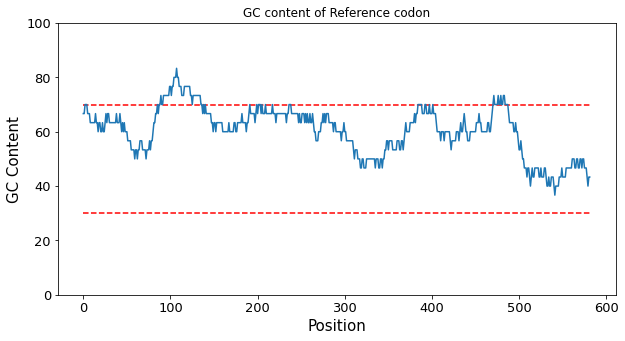

In [14]:
codon_opt = outcome_codon_seq_cqm(selected_codon, 'DNA')
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
dp_metrics('Optimal Codon Seq by using Hybrid Solver', opt_codon_seq)

## 3. Results

46 feasible solutions of 52.
Optimal Codon Seq by using Hybrid Solver
----------------------------------------
CAI for human: 0.6394400137350943
CAI for ecoli: 0.8696531616573949
CPB for human: -0.047794168853049955
CPB for ecoli: 0.206776566681687
Effective number of codons: 28.71699694865958
Similarity to ref_codon: 0.7875816993464052
GC: 59.967320261437905
GC3: 58.333333333333336


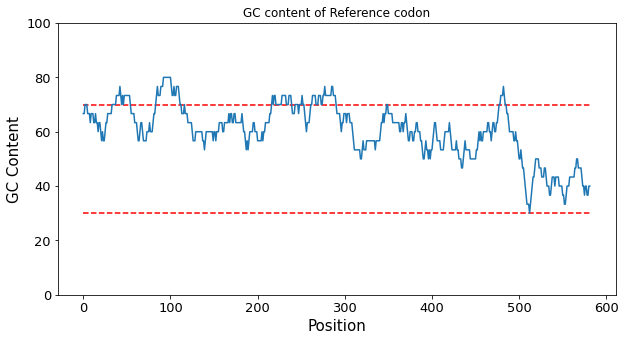

In [15]:
weight_params = {'cub_ec': 1, 'cub_hu': 0, 'cpub_ec': 1, 'cpub_hu': 0, 'rep_nuc': 0, 'rho_T': 0.55, 'B_rho': 0.05}
H_codon = Codon_Hamiltonian(HPDF_amino, weight_params)
codon_opt = H_codon.run_Hybrid()

opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
dp_metrics('Optimal Codon Seq by using Hybrid Solver', opt_codon_seq, ref_codon=ref_HPDF_DNA)

43 feasible solutions of 51.
Optimal Codon Seq by using Hybrid Solver
----------------------------------------
CAI for human: 0.6521516203596237
CAI for ecoli: 0.7267317709970225
CPB for human: -0.18012531517751462
CPB for ecoli: 0.13983310323513423
Effective number of codons: 33.24035479882746
Similarity to ref_codon: 0.7810457516339869
GC: 59.967320261437905
GC3: 57.35294117647059


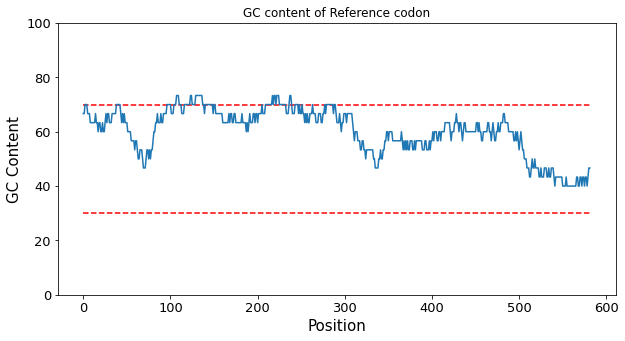

In [16]:
weight_params = {'cub_ec': 1, 'cub_hu': 0, 'cpub_ec': 1, 'cpub_hu': 0, 'rep_nuc': 1, 'rho_T': 0.55, 'B_rho': 0.05}
H_codon = Codon_Hamiltonian(HPDF_amino, weight_params)
codon_opt = H_codon.run_Hybrid()

opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
dp_metrics('Optimal Codon Seq by using Hybrid Solver', opt_codon_seq, ref_codon=ref_HPDF_DNA)

43 feasible solutions of 52.
Optimal Codon Seq by using Hybrid Solver
----------------------------------------
CAI for human: 0.8089417353063131
CAI for ecoli: 0.7587040657977652
CPB for human: 0.16457549911142852
CPB for ecoli: 0.1400254383707891
Effective number of codons: 30.312500508596955
Similarity to ref_codon: 0.7941176470588235
GC: 59.967320261437905
GC3: 60.294117647058826


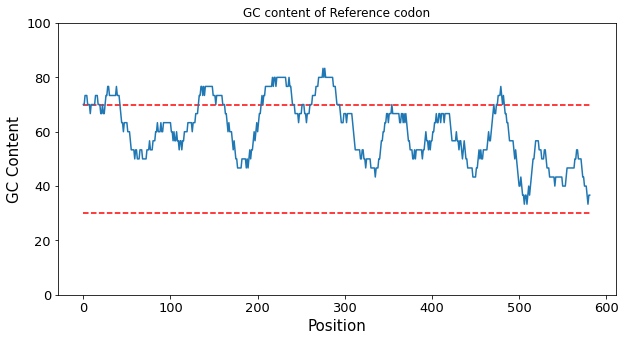

In [17]:
weight_params = {'cub_ec': 1, 'cub_hu': 1, 'cpub_ec': 1, 'cpub_hu': 1, 'rep_nuc': 0, 'rho_T': 0.55, 'B_rho': 0.05}
H_codon = Codon_Hamiltonian(HPDF_amino, weight_params)
codon_opt = H_codon.run_Hybrid()

opt_codon_seq = ["".join(c) for c in [codon_opt]][0]
dp_metrics('Optimal Codon Seq by using Hybrid Solver', opt_codon_seq, ref_codon=ref_HPDF_DNA)